# Specter embeddings

In this notebook, we perform a clustering analysis of COVID-19 publications using [SPECTRE embeddings](https://github.com/allenai/paper-embedding-public-apis).

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_meta = pd.read_csv("data/df_meta.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [3]:
df_meta.abstract = df_meta['abstract'].fillna('')
df_meta.title = df_meta['title'].fillna('')

In [4]:
df_meta.head()

pub_id                                              title  \
0       0  Coronavirus disease 2019 (COVID-19) and simult...   
1       1  [Ten hot issues of breast cancer under the nov...   
2       2                            Cohesion in Distancing.   
3       3                     Salvation in a Time of Plague.   
4       4  What Should Health Science Journalists Do in E...   

                                            abstract  publication_year  \
0  Coronavirus disease 2019 (COVID-19) is a recen...            2020.0   
1                                                               2020.0   
2  In isolation, we are physically apart; in soli...            2020.0   
3  Health workers offer their skills and care to ...            2020.0   
4  Journalists have long covered outbreaks of inf...            2020.0   

   publication_month                           journal volume issue     pages  \
0                5.0  CardioVascular Journal of Africa     31   NaN       1-4   
1                2.0           Chinese medical journal    100     0      e002   
2                4.0          The AMA Journal of Ethic     22     4  e344-345   
3                5.0          The AMA Journal of Ethic     22     5  e441-445   
4                1.0             AMA journal of ethics    NaN   NaN       NaN   

                                      doi        pmid pmcid   dimensions_id  \
0                   10-5830-cvja-2020-016  32490506.0   NaN  pub.1128171889   
1  10.0376/cma.j.issn.0376-2491.2020.0002  32036640.0   NaN  pub.1124777091   
2             10.1001/amajethics.2020.344  32345430.0   NaN  pub.1127182341   
3             10.1001/amajethics.2020.441  32449663.0   NaN  pub.1127905371   
4              10.1001/amajethics.2020.55  31958392.0   NaN             NaN   

  arxiv_id                   timestamp lang  
0      NaN  2020-07-02 10:54:27.347501   en  
1      NaN  2020-07-02 10:54:27.347501   en  
2      NaN  2020-07-02 10:54:27.347501   en  
3      NaN  2020-07-02 10:54:27.347501   en  
4      NaN  2020-07-02 10:54:27.347501   en

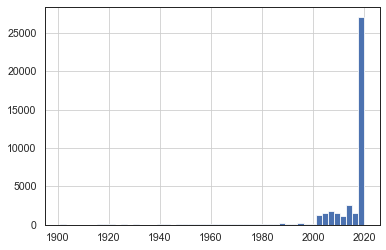

In [5]:
df_meta[(df_meta.abstract=="") & (df_meta.publication_year<2021)].publication_year.hist(bins=50)

In [6]:
ALL_PAPERS = list()
for pid,t,a in zip(df_meta[df_meta.lang=='en'].pub_id.to_list(),df_meta[df_meta.lang=='en'].title.to_list(),df_meta[df_meta.lang=='en'].abstract.to_list()):
    if len(t) and len(a):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":a})
    elif len(t):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":t}) # we use the title as abstract
    else:
        continue

In [7]:
df_meta.shape

(160656, 16)

In [8]:
len(ALL_PAPERS)

152247

In [9]:
paper_to_id = {n:pid["paper_id"] for n,pid in enumerate(ALL_PAPERS)}

### Query SPECTER API

In [10]:
# From https://github.com/allenai/paper-embedding-public-apis

from typing import Dict, List
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16


def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]


def embed(papers):
    embeddings_by_paper_id: Dict[str, List[float]] = {}
        
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    for n,chunk in enumerate(chunks(papers)):
        # Allow Python requests to convert the data above to JSON
        response = session.post(URL, json=chunk)

        if response.status_code != 200:
            print(chunk)
            #raise RuntimeError("Sorry, something went wrong, please try later!")
            continue

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]
        #print(n)
        if n%1000 == 0:
            print("Done chunk",n)

    return embeddings_by_paper_id

In [11]:
all_embeddings = embed(ALL_PAPERS)

Done chunk 0
Done chunk 1000
Done chunk 2000
Done chunk 3000
Done chunk 4000
Done chunk 5000
Done chunk 6000
Done chunk 7000
Done chunk 8000
Done chunk 9000


In [12]:
pickle.dump(all_embeddings,open("data/specter_embeddings.pk","wb"))

In [20]:
all_embeddings = pickle.load(open("data/specter_embeddings.pk","rb"))

In [13]:
len(all_embeddings)

152247

In [14]:
len(ALL_PAPERS)

152247

In [15]:
X = np.matrix([v for v in all_embeddings.values()])

In [16]:
X.shape

(152247, 768)

### t-SNE

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, perplexity=50, early_exaggeration=15, n_iter=2000, random_state=seed, metric='cosine', n_jobs=6)
X_embedded = tsne.fit_transform(X)

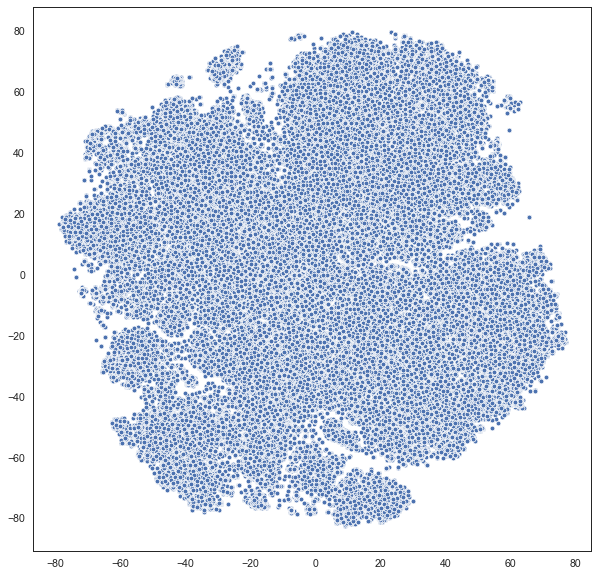

In [18]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=sns.color_palette("bright", 1))
#plt.title('t-SNE with no Labels')
plt.savefig("figures/nb3_tsne_vanilla.pdf")
plt.show()

In [19]:
# create a vector with in_wikipedia or not for all papers with embeddings

y = list()
             
inwiki = df_joined_all[df_joined_all.in_wikipedia==1].pub_id.to_list()
                 
for n,k in enumerate(all_embeddings.keys()):
    if k in inwiki:
        y.append(1)
    else:
        y.append(0)

In [20]:
y = np.array(y)

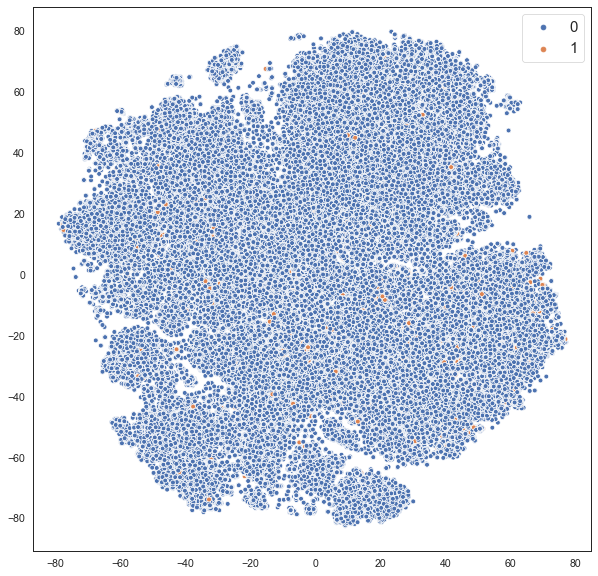

In [21]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=15)
plt.savefig("figures/nb3_tsne_in_wiki.pdf")
plt.show()

### K-means

In [22]:
# number of clusters
# see below for Elbow and Silouhette analyses 
k = 20

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, random_state=seed, max_iter=1000, n_jobs=6)
y_pred = kmeans.fit_predict(X)

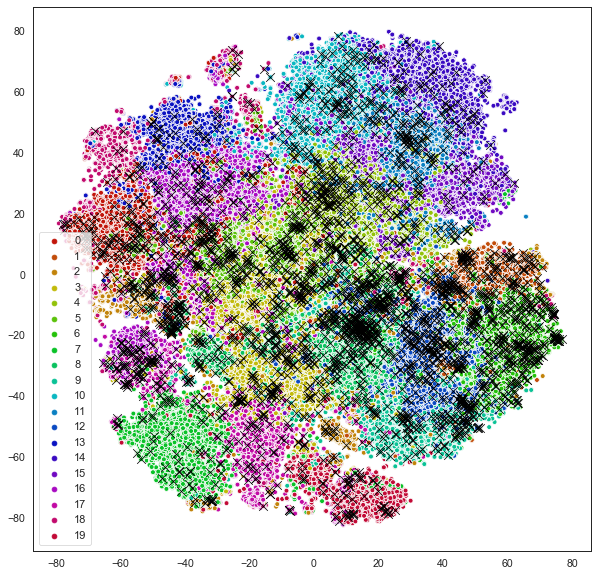

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=sns.hls_palette(20, l=.4, s=.9))
sns.scatterplot(X_embedded[y==1][:,0], X_embedded[y==1][:,1], legend=False, marker="x", color="black", s=75)
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=11)
plt.savefig("figures/nb3_tsne_kmeans_in_wiki.pdf")
plt.show()

In [25]:
# list closest 10 papers to centroids
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X, metric='cosine')
closest

array([118397, 115939,  39186,  30285,    713,  72269,  92046,  15626,
       101907,  19424,  23498, 122044,  61276,  99067,  25970, 131946,
        81039, 133943, 121531, 107084])

In [26]:
for n,c in enumerate(closest):
    print("Cluster",n,df_meta.iloc[paper_to_id[c]].title)

Cluster 0 Trend Prediction and Intervention of the COVID-19 Pandemic: A Modelling Study
Cluster 1 Natural compounds as potential inhibitors of novel coronavirus (COVID-19) main protease: An in silico study
Cluster 2 Reprint of bioaerosol: A bridge and opportunity for many scientific research fields
Cluster 3 Severe and fatal forms of COVID-19 in children
Cluster 4 Inclusion of Children in Clinical Trials of Treatments for Coronavirus Disease 2019 (COVID-19)
Cluster 5 The epidemiology and therapeutic options for the COVID-19
Cluster 6 Mutagenesis of Coronavirus nsp14 Reveals Its Potential Role in Modulation of the Innate Immune Response.
Cluster 7 Extending the reach of stapled anastomosis with a prepared OrVil™ device in laparoscopic oesophageal and gastric cancer surgery.
Cluster 8 S1 gene sequence analysis of a nephropathogenic strain of avian infectious bronchitis virus in Egypt
Cluster 9 Potential role for tissue factor in the pathogenesis of hypercoagulability associated with in C

In [27]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [28]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for c in range(k):
    cl_size = len(y_pred[y_pred==c])
    coverage = len(y_pred[(y==1)&(y_pred==c)])/cl_size
    #print("Cluster",c,coverage)
    cluster_coverage.append(coverage)
    cluster_size.append(cl_size)
    cluster_number.append(c)

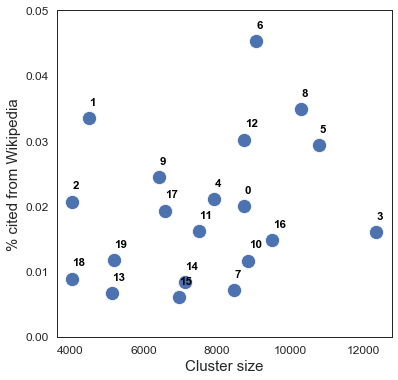

In [111]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in range(k+1):
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.05))
#plt.xlim((0,max(cluster_size)+500))
plt.tick_params(labelsize=12)
plt.ylabel("% cited from Wikipedia",fontsize=15)
plt.xlabel("Cluster size",fontsize=15)
plt.savefig("figures/nb3_cluster_size_vs_wiki_coverage.pdf")

In [32]:
# export cluster identity and semantic centrality of each paper

from sklearn.metrics.pairwise import cosine_similarity

cluster_semantic_similarities = list()

for k,centroid in enumerate(kmeans.cluster_centers_):
    cos_sim = cosine_similarity(centroid.reshape((1,X.shape[1])), X)
    cluster_semantic_similarities.append(cos_sim)

In [33]:
S = np.stack([s.ravel() for s in cluster_semantic_similarities],axis=1)

In [34]:
S.shape

(152247, 20)

In [35]:
# find the similarity with cluster centroid
T = S[np.arange(len(S)),y_pred]

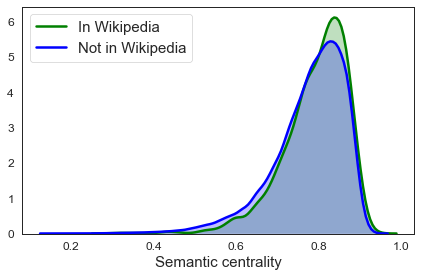

In [36]:
# distribution of semantic centrality for papers cited from Wikipedia or not
#plt.figure(figsize=(10,8))
sns.distplot(T[y==1], color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(T[y==0], color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("Semantic centrality",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb3_semantic_centrality.pdf")

In [37]:
# create data frame and export

In [38]:
pub_ids = list()
cluster_ids = list()
semantic_centralities = list()
cluster_sizes = list()

for n in range(len(y)):
    pub_ids.append(paper_to_id[n])
    cluster_ids.append(y_pred[n])
    semantic_centralities.append(T[n])
    cluster_sizes.append(len(y_pred[y_pred==y_pred[n]]))

In [39]:
df_specter = pd.DataFrame.from_dict({"pub_id":pub_ids,"spectre_cluster_id":cluster_ids,"spectre_cluster_size":cluster_sizes,"spectre_semantic_centrality":semantic_centralities})
df_specter.to_csv("data/df_spectre.csv", index=False, compression="gzip")

### Topic models

In [40]:
# you can select here if to use an LDA or a CTM topic model
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
#df_topic_intensity = pd.read_csv("data/df_topic_intensity_ctm.csv", compression="gzip")
df_specter = pd.read_csv("data/df_spectre.csv", compression="gzip")

In [41]:
df_topic_intensity.head()

tm_coronaviruses  tm_epidemics     tm_ph  tm_mbi  tm_clinical_medicine  \
0          0.335269      0.091129  0.111784     0.0              0.457265   
1          0.299387      0.000000  0.198364     0.0              0.422208   
2          0.000000      0.000000  0.953206     0.0              0.000000   
3          0.000000      0.141524  0.674861     0.0              0.165509   
4          0.000000      0.676764  0.307801     0.0              0.000000   

   pub_id  
0       0  
1       1  
2       2  
3       3  
4       4

In [42]:
df_topic_intensity.columns

Index(['tm_coronaviruses', 'tm_epidemics', 'tm_ph', 'tm_mbi',
       'tm_clinical_medicine', 'pub_id'],
      dtype='object')

In [43]:
topic_labels = ['tm_coronaviruses', 'tm_epidemics', 'tm_ph', 'tm_mbi',
       'tm_clinical_medicine']

In [44]:
tm_names = {"Coronaviruses": "tm_coronaviruses",
    "Epidemics": "tm_epidemics",
    "Public health": "tm_ph",
    "Molecular biology and immunology": "tm_mbi",
    "Clinical medicine": "tm_clinical_medicine"}
topic_labels = [x for x in tm_names.keys()]
reverse_tm_names = {x:y for y,x in tm_names.items()}
df_topic_intensity.rename(columns=reverse_tm_names,inplace=True)

In [45]:
df_embeddings = df_specter[["pub_id","spectre_cluster_id"]]

In [46]:
df_embeddings.shape

(152247, 2)

In [47]:
df_topic_intensity.shape

(152247, 6)

In [48]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")
df_embeddings = df_embeddings.merge(df_meta[["pub_id","publication_year"]], how="inner", left_on="pub_id", right_on="pub_id")

In [49]:
df_embeddings.shape

(152247, 8)

In [120]:
which_cluster = 18

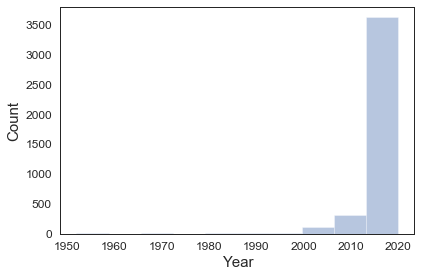

In [121]:
#plt.figure(figsize=(9,6))
sns.distplot(df_embeddings[df_embeddings.spectre_cluster_id == which_cluster].publication_year, bins=10, kde=False)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
#plt.savefig("figures/nb3_cluster_%d_yeardistr.pdf"%(which_cluster))

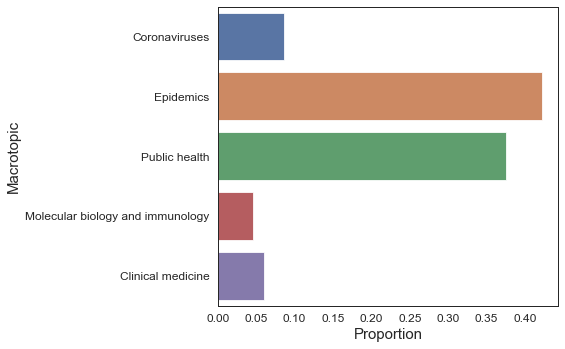

In [122]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.spectre_cluster_id == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("figures/nb3_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [123]:
# examples of central papers in a cluster

df_specter[df_specter.spectre_cluster_id==which_cluster].merge(df_meta[["title","publication_year","journal","pub_id"]], how="left", right_on="pub_id", left_on="pub_id").sort_values("spectre_semantic_centrality",ascending=False).head(10)

pub_id  spectre_cluster_id  spectre_cluster_size  \
3225  128186                  18                  4052   
3184  128108                  18                  4052   
3251  128255                  18                  4052   
2883  113637                  18                  4052   
3112  127934                  18                  4052   
3152  128017                  18                  4052   
3115  127940                  18                  4052   
3245  128246                  18                  4052   
3281  130452                  18                  4052   
3280  130451                  18                  4052   

      spectre_semantic_centrality  \
3225                     0.820833   
3184                     0.812080   
3251                     0.809512   
2883                     0.808924   
3112                     0.806107   
3152                     0.802578   
3115                     0.802547   
3245                     0.800476   
3281                     0.791251   
3280                     0.791251   

                                                  title  publication_year  \
3225  Prediction of the Number of COVID-19 Confirmed...            2020.0   
3184  COVID-19 in India: State-wise Analysis and Pre...            2020.0   
3251  Statistical Analytics and Regional Representat...            2020.0   
2883               Dynamic causal modelling of COVID-19            2020.0   
3112  Cardiovascular disease in the literature: A se...            2020.0   
3152  Role of machine learning algorithms in timely ...            2020.0   
3115  Machine Learning Approach for Confirmation of ...            2020.0   
3245  Dynamics and Development of the COVID-19 Epide...            2020.0   
3281  Text and Network-Mining for COVID-19 Intervent...            2020.0   
3280  Text and Network-Mining for COVID-19 Intervent...            2020.0   

                     journal  
3225          JMIR Preprints  
3184          JMIR Preprints  
3251          JMIR Preprints  
2883  Wellcome Open Research  
3112          JMIR Preprints  
3152          JMIR Preprints  
3115          JMIR Preprints  
3245          JMIR Preprints  
3281                ChemRxiv  
3280                ChemRxiv

#### Topics cited from Wikipedia or not

In [54]:
df_embeddings_tm = df_embeddings.merge(df_joined_all[["pub_id","in_wikipedia","title"]], how="left", left_on="pub_id", right_on="pub_id")
df_embeddings_tm.in_wikipedia = df_embeddings_tm['in_wikipedia'].fillna(False)

In [55]:
df_embeddings_tm.shape

(152247, 10)

#### Overall

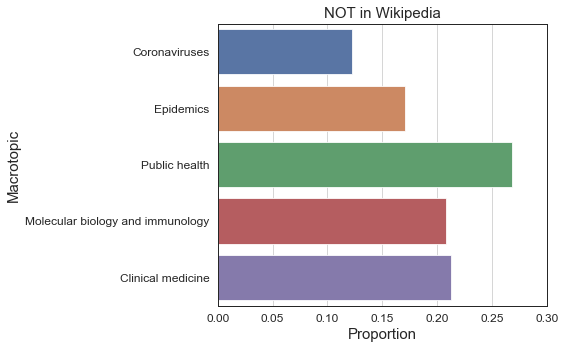

In [56]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_title("NOT in Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW.pdf")

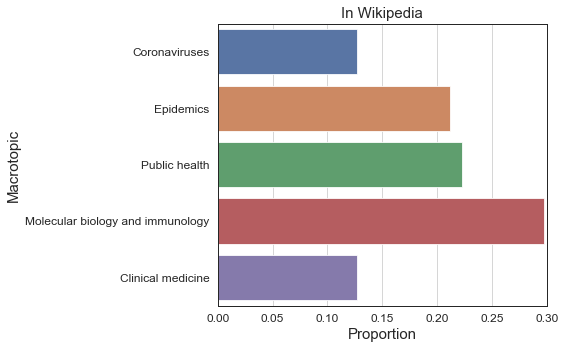

In [57]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W.pdf")

In [58]:
df_melted = df_embeddings_tm[topic_labels+["pub_id"]].melt(id_vars=["pub_id"], var_name='topic_intensity')
df_melted = df_melted.merge(df_embeddings_tm[["pub_id","in_wikipedia","publication_year"]], how="left", left_on="pub_id", right_on="pub_id")

In [59]:
df_embeddings_tm.shape

(152247, 10)

In [60]:
df_melted.shape

(761235, 5)

In [61]:
df_embeddings_tm.shape[0] * len(topic_labels)

761235

In [62]:
df_melted.head()

pub_id topic_intensity     value  in_wikipedia  publication_year
0       0   Coronaviruses  0.335269         False            2020.0
1       1   Coronaviruses  0.299387         False            2020.0
2       2   Coronaviruses  0.000000         False            2020.0
3       3   Coronaviruses  0.000000         False            2020.0
4       4   Coronaviruses  0.000000         False            2020.0

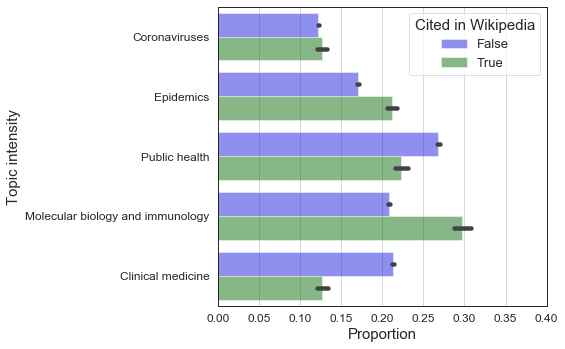

In [87]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted, estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Topic intensity",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_ALL.pdf")

In [64]:
# https://en.wikipedia.org/wiki/Effect_size#Cohen's_d

def cohensd(d1, d2):
    # sample size
    n1, n2 = len(d1), len(d2)
    # variance
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # s
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # u
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [65]:
from scipy import stats
cohens_d_all = list()
kruskal_all = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][mt].values,df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][mt].values))
    cohens_d_all.append(cod)
    kr = stats.kruskal(df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][mt].values,df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][mt].values)
    kruskal_all.append(kr)
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.024984650754994314 0.6778801608226929
Epidemics 0.2211918064044389 9.786602027286595e-51
Public health 0.16693723933983523 3.2503322492634435e-13
Molecular biology and immunology 0.3092160121061112 1.180162944466457e-76
Clinical medicine 0.32328675133808865 4.874349659619025e-74


#### 2020

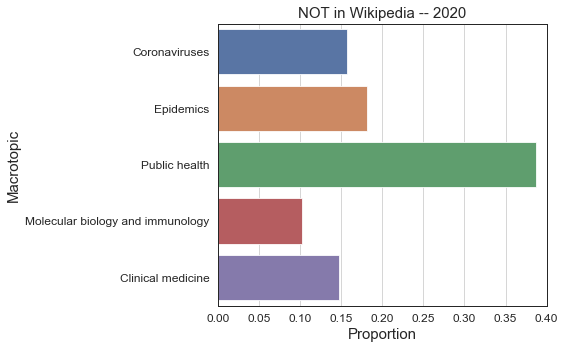

In [66]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year==2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_2020.pdf")

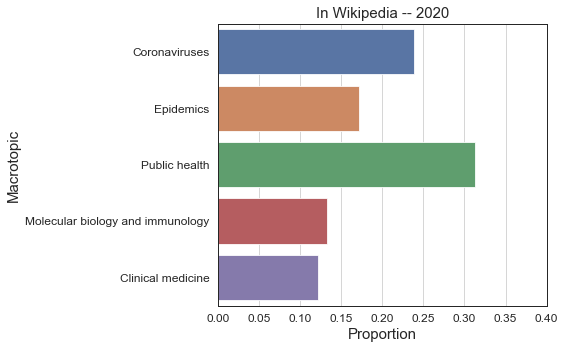

In [67]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year==2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_2020.pdf")

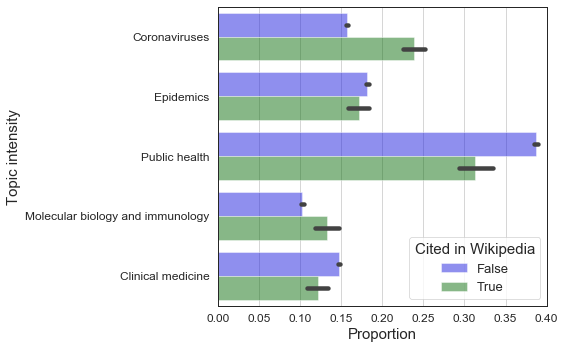

In [88]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted[df_melted.publication_year==2020], estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Topic intensity",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_2020.pdf")

In [69]:
cohens_d_2020 = list()
kruskal_2020 = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values))
    cohens_d_2020.append(cod)
    kr = stats.kruskal(df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
    kruskal_2020.append(kr)
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.4479497215025275 4.0360183522791464e-39
Epidemics 0.054960700360037765 0.8399325351634439
Public health 0.26098840854546956 7.510678642647582e-12
Molecular biology and immunology 0.1590625269593304 0.00010314049740424341
Clinical medicine 0.13887124614352384 9.00637122798505e-06


#### Before 2020

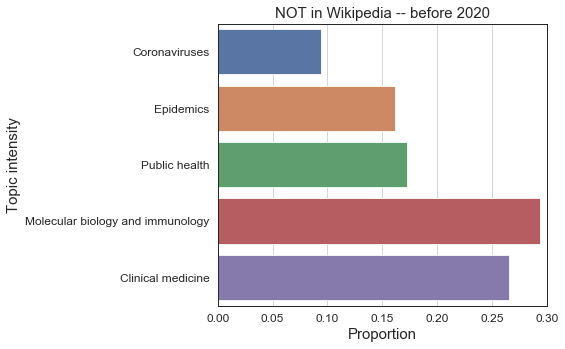

In [89]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year<2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Topic intensity",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_before_2020.pdf")

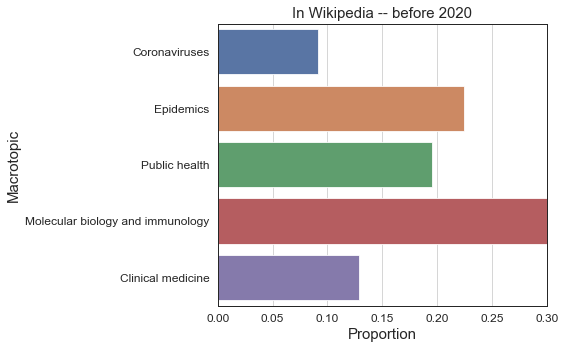

In [71]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year<2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_before_2020.pdf")

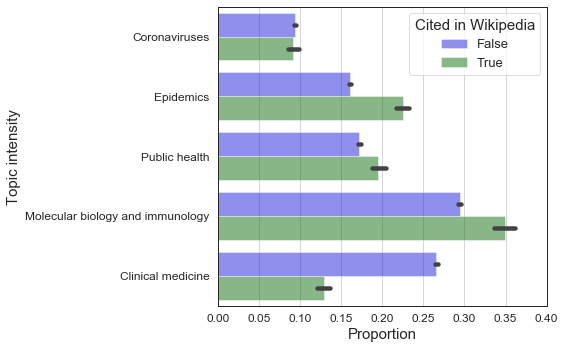

In [90]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted[df_melted.publication_year<2020], estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Topic intensity",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_before_2020.pdf")

In [77]:
cohens_d_before = list()
kruskal_before = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values))
    cohens_d_before.append(cod)
    kr = stats.kruskal(df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
    kruskal_before.append(kr)
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.014971403256806721 0.8070317013625489
Epidemics 0.34082991562018644 8.314589025482428e-80
Public health 0.10732218565228198 3.0398182448675844e-09
Molecular biology and immunology 0.16970191872258106 3.494642257167308e-24
Clinical medicine 0.4503064176882843 2.498536055309177e-105


In [78]:
def p_to_ast(p):
    if p < 0.01:
        return "***"
    elif p <= 0.05:
        return "**"
    elif p <= 0.1:
        return "*"
    return " "
    
df_tests = pd.DataFrame.from_dict({"macrotopic":topic_labels,"cohensd_all":cohens_d_all,"cohensd_2020":cohens_d_2020,"cohensd_before":cohens_d_before,
                                  "kwh_p_all":[k.pvalue for k in kruskal_all],"kwh_p_2020":[k.pvalue for k in kruskal_2020],"kwh_p_before":[k.pvalue for k in kruskal_before],
                                   "kwh_ps_all":[p_to_ast(k.pvalue) for k in kruskal_all],"kwh_ps_2020":[p_to_ast(k.pvalue) for k in kruskal_2020],"kwh_ps_before":[p_to_ast(k.pvalue) for k in kruskal_before],
                                  "kwh_stat_all":[k.statistic for k in kruskal_all],"kwh_stat_2020":[k.statistic for k in kruskal_2020],"kwh_stat_before":[k.statistic for k in kruskal_before]})
#df_tests["id"] = df_tests.index

In [79]:
df_tests

macrotopic  cohensd_all  cohensd_2020  \
0                     Coronaviruses     0.024985      0.447950   
1                         Epidemics     0.221192      0.054961   
2                     Public health     0.166937      0.260988   
3  Molecular biology and immunology     0.309216      0.159063   
4                 Clinical medicine     0.323287      0.138871   

   cohensd_before     kwh_p_all    kwh_p_2020   kwh_p_before kwh_ps_all  \
0        0.014971  6.778802e-01  4.036018e-39   8.070317e-01              
1        0.340830  9.786602e-51  8.399325e-01   8.314589e-80        ***   
2        0.107322  3.250332e-13  7.510679e-12   3.039818e-09        ***   
3        0.169702  1.180163e-76  1.031405e-04   3.494642e-24        ***   
4        0.450306  4.874350e-74  9.006371e-06  2.498536e-105        ***   

  kwh_ps_2020 kwh_ps_before  kwh_stat_all  kwh_stat_2020  kwh_stat_before  
0         ***                    0.172522     171.205159         0.059662  
1                       ***    224.427700       0.040796       357.840371  
2         ***           ***     53.050796      46.889428        35.158180  
3         ***           ***    343.365468      15.078331       102.917133  
4         ***           ***    331.353860      19.711374       475.092180

In [80]:
df_melted_tests = df_tests.melt(id_vars=["macrotopic"])

In [81]:
df_melted_tests["period"] = df_melted_tests["variable"].apply(lambda x:x.split("_")[-1])
df_melted_tests["variable"] = df_melted_tests["variable"].apply(lambda x:"_".join(x.split("_")[:-1]))

In [82]:
df_melted_tests

macrotopic  variable         value  period
0                      Coronaviruses   cohensd     0.0249847     all
1                          Epidemics   cohensd      0.221192     all
2                      Public health   cohensd      0.166937     all
3   Molecular biology and immunology   cohensd      0.309216     all
4                  Clinical medicine   cohensd      0.323287     all
5                      Coronaviruses   cohensd       0.44795    2020
6                          Epidemics   cohensd     0.0549607    2020
7                      Public health   cohensd      0.260988    2020
8   Molecular biology and immunology   cohensd      0.159063    2020
9                  Clinical medicine   cohensd      0.138871    2020
10                     Coronaviruses   cohensd     0.0149714  before
11                         Epidemics   cohensd       0.34083  before
12                     Public health   cohensd      0.107322  before
13  Molecular biology and immunology   cohensd      0.169702  before
14                 Clinical medicine   cohensd      0.450306  before
15                     Coronaviruses     kwh_p       0.67788     all
16                         Epidemics     kwh_p    9.7866e-51     all
17                     Public health     kwh_p   3.25033e-13     all
18  Molecular biology and immunology     kwh_p   1.18016e-76     all
19                 Clinical medicine     kwh_p   4.87435e-74     all
20                     Coronaviruses     kwh_p   4.03602e-39    2020
21                         Epidemics     kwh_p      0.839933    2020
22                     Public health     kwh_p   7.51068e-12    2020
23  Molecular biology and immunology     kwh_p    0.00010314    2020
24                 Clinical medicine     kwh_p   9.00637e-06    2020
25                     Coronaviruses     kwh_p      0.807032  before
26                         Epidemics     kwh_p   8.31459e-80  before
27                     Public health     kwh_p   3.03982e-09  before
28  Molecular biology and immunology     kwh_p   3.49464e-24  before
29                 Clinical medicine     kwh_p  2.49854e-105  before
30                     Coronaviruses    kwh_ps                   all
31                         Epidemics    kwh_ps           ***     all
32                     Public health    kwh_ps           ***     all
33  Molecular biology and immunology    kwh_ps           ***     all
34                 Clinical medicine    kwh_ps           ***     all
35                     Coronaviruses    kwh_ps           ***    2020
36                         Epidemics    kwh_ps                  2020
37                     Public health    kwh_ps           ***    2020
38  Molecular biology and immunology    kwh_ps           ***    2020
39                 Clinical medicine    kwh_ps           ***    2020
40                     Coronaviruses    kwh_ps                before
41                         Epidemics    kwh_ps           ***  before
42                     Public health    kwh_ps           ***  before
43  Molecular biology and immunology    kwh_ps           ***  before
44                 Clinical medicine    kwh_ps           ***  before
45                     Coronaviruses  kwh_stat      0.172522     all
46                         Epidemics  kwh_stat       224.428     all
47                     Public health  kwh_stat       53.0508     all
48  Molecular biology and immunology  kwh_stat       343.365     all
49                 Clinical medicine  kwh_stat       331.354     all
50                     Coronaviruses  kwh_stat       171.205    2020
51                         Epidemics  kwh_stat     0.0407958    2020
52                     Public health  kwh_stat       46.8894    2020
53  Molecular biology and immunology  kwh_stat       15.0783    2020
54                 Clinical medicine  kwh_stat       19.7114    2020
55                     Coronaviruses  kwh_stat     0.0596615  before
56                         Epidemics  kwh_stat        357.84  before
57                     P

In [83]:
# effect and test tables 

# EXAMPLE row for paper:
# Coronaviruses & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{52} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} \\

table_item = "\multicolumn{1}{r}{%s}"
for period in ["before","2020","all"]:
    print("==== %s ===="%period)
    condition = df_embeddings.publication_year<3000
    if period == "before":
        condition = df_embeddings.publication_year<2020
    elif period == "2020":
        condition = df_embeddings.publication_year==2020
    for mt in topic_labels:
        mean_in = np.mean(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
        sd_in = np.std(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
        mean_not = np.mean(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == False)][mt].values)
        sd_not = np.std(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == False)][mt].values)
        kwh = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="kwh_stat")].value
        p = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="kwh_p")].value
        cd = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="cohensd")].value
        row_values = [mean_in,sd_in,mean_not,sd_not,kwh,p,cd]
        print(mt,"&"," & ".join([table_item%format(round(float(v),3)) for v in row_values]),"\\\\")
    print("\n")

==== before ====
Coronaviruses & \multicolumn{1}{r}{0.092} & \multicolumn{1}{r}{0.156} & \multicolumn{1}{r}{0.094} & \multicolumn{1}{r}{0.165} & \multicolumn{1}{r}{0.06} & \multicolumn{1}{r}{0.807} & \multicolumn{1}{r}{0.015} \\
Epidemics & \multicolumn{1}{r}{0.225} & \multicolumn{1}{r}{0.197} & \multicolumn{1}{r}{0.161} & \multicolumn{1}{r}{0.186} & \multicolumn{1}{r}{357.84} & \multicolumn{1}{r}{0.0} & \multicolumn{1}{r}{0.341} \\
Public health & \multicolumn{1}{r}{0.195} & \multicolumn{1}{r}{0.222} & \multicolumn{1}{r}{0.172} & \multicolumn{1}{r}{0.215} & \multicolumn{1}{r}{35.158} & \multicolumn{1}{r}{0.0} & \multicolumn{1}{r}{0.107} \\
Molecular biology and immunology & \multicolumn{1}{r}{0.349} & \multicolumn{1}{r}{0.313} & \multicolumn{1}{r}{0.294} & \multicolumn{1}{r}{0.324} & \multicolumn{1}{r}{102.917} & \multicolumn{1}{r}{0.0} & \multicolumn{1}{r}{0.17} \\
Clinical medicine & \multicolumn{1}{r}{0.129} & \multicolumn{1}{r}{0.198} & \multicolumn{1}{r}{0.266} & \multicolumn{1}{

In [84]:
"\multicolumn{1}{r}{%s}"%format(round(2.44444,2))

'\\multicolumn{1}{r}{2.44}'

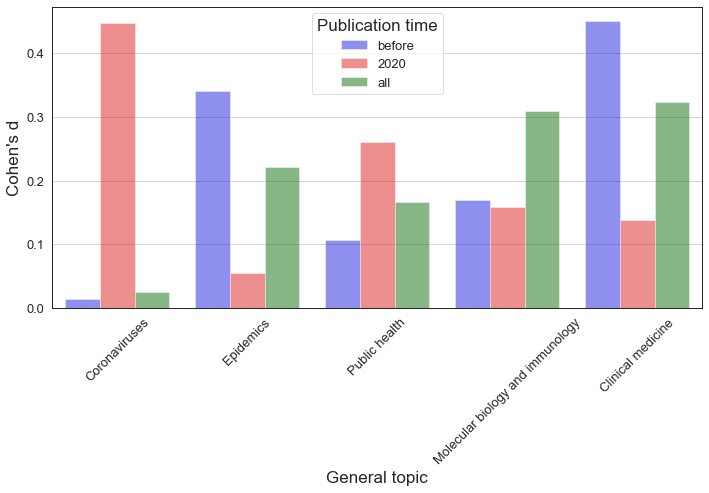

In [125]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="value", x="macrotopic", hue="period", hue_order=["before","2020","all"], data=df_melted_tests[df_melted_tests.variable.isin(["cohensd"])], palette=["blue","red","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("General topic",fontsize=17)
b.set_ylabel("Cohen's d",fontsize=17)
#b.set_title("Clustering")
b.tick_params(labelsize=13)
b.set_xticklabels(b.get_xticklabels(), rotation=45)

"""for n,p in enumerate(ax.patches):
    _x = p.get_x() + p.get_width() - 0.16
    _y = p.get_y() + p.get_height() + 0.003
    print(significances[n])
    value = significances[n]
    ax.text(_x, _y, str(value), ha="left")
""" 
#plt.xlim((0,0.4))
plt.legend(title="Publication time", fontsize=13, title_fontsize=17)
plt.tight_layout()
plt.savefig("figures/nb3_cohens_d.pdf")

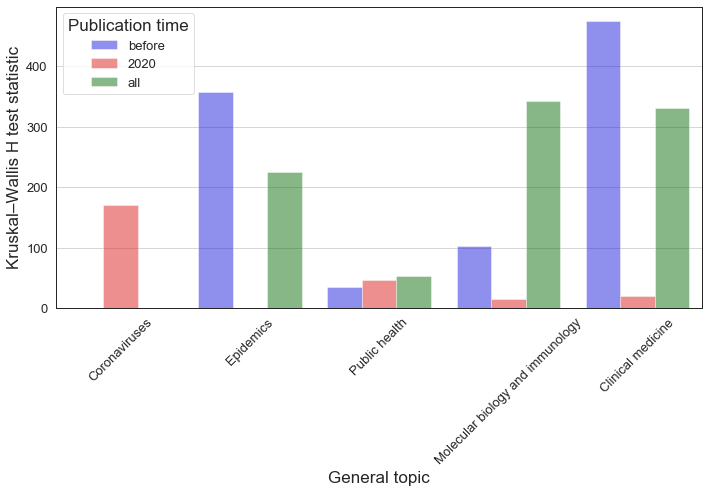

In [124]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="value", x="macrotopic", hue="period", hue_order=["before","2020","all"], data=df_melted_tests[df_melted_tests.variable.isin(["kwh_stat"])], palette=["blue","red","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("General topic",fontsize=17)
b.set_ylabel("Kruskal–Wallis H test statistic",fontsize=17)
#b.set_title("Clustering")
b.tick_params(labelsize=13)
b.set_xticklabels(b.get_xticklabels(), rotation=45)

"""
for p in ax.patches:
    _x = p.get_x() + p.get_width() - 0.16
    _y = p.get_y() + p.get_height() + 1
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")
"""               
#plt.xlim((0,0.4))
plt.legend(title="Publication time", fontsize=13, title_fontsize=17)
plt.tight_layout()
#plt.savefig("figures/nb3_topic_model_hue_before_2020.pdf")

### Find a good value for the number of clusters (k-means)

#### Elbow method

In [42]:
# use PCA to reduce embedding size first (makes computations faster)
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=seed)
X_reduced= pca.fit_transform(X)
X_reduced.shape

(61324, 333)

In [45]:
# calculate distortions
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
values = range(10, 50)
for k in values:
    k_means = KMeans(n_clusters=k, random_state=seed).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

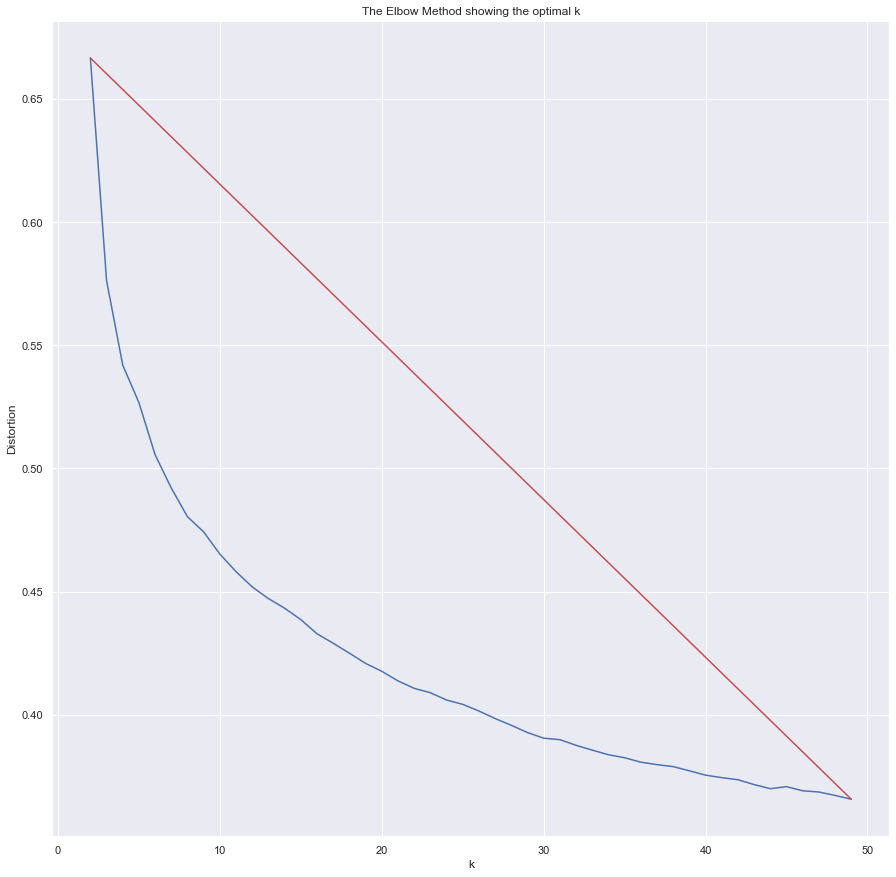

In [46]:
X_line = [values[0], values[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(values, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

#### Silhouette method

For n_clusters = 10 The average silhouette_score is : 0.055897716897725165
For n_clusters = 15 The average silhouette_score is : 0.04894153670518214
For n_clusters = 20 The average silhouette_score is : 0.04936273055262579
For n_clusters = 25 The average silhouette_score is : 0.047662626535926025
For n_clusters = 30 The average silhouette_score is : 0.04502606848610148
For n_clusters = 35 The average silhouette_score is : 0.045655548179418234
For n_clusters = 40 The average silhouette_score is : 0.045706688074604505
For n_clusters = 45 The average silhouette_score is : 0.04357707523742458
For n_clusters = 50 The average silhouette_score is : 0.04174141411594277


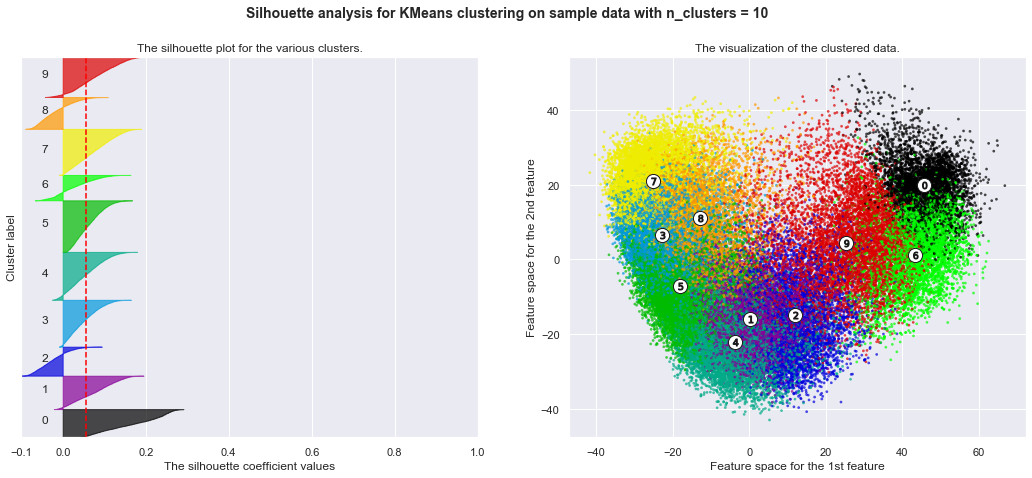

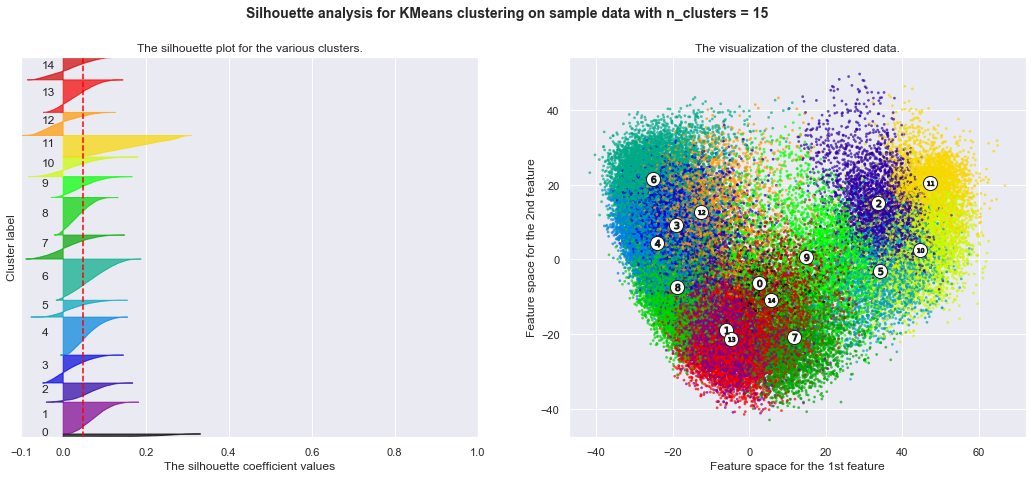

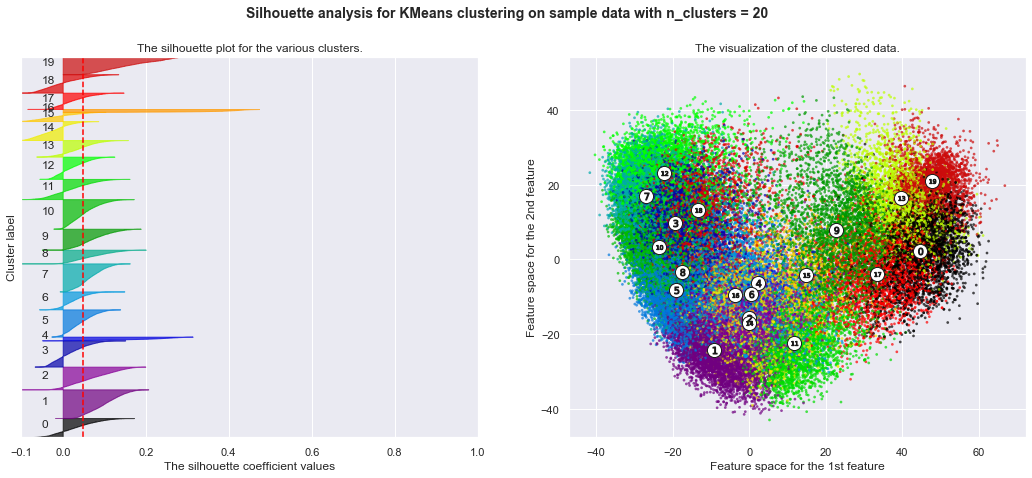

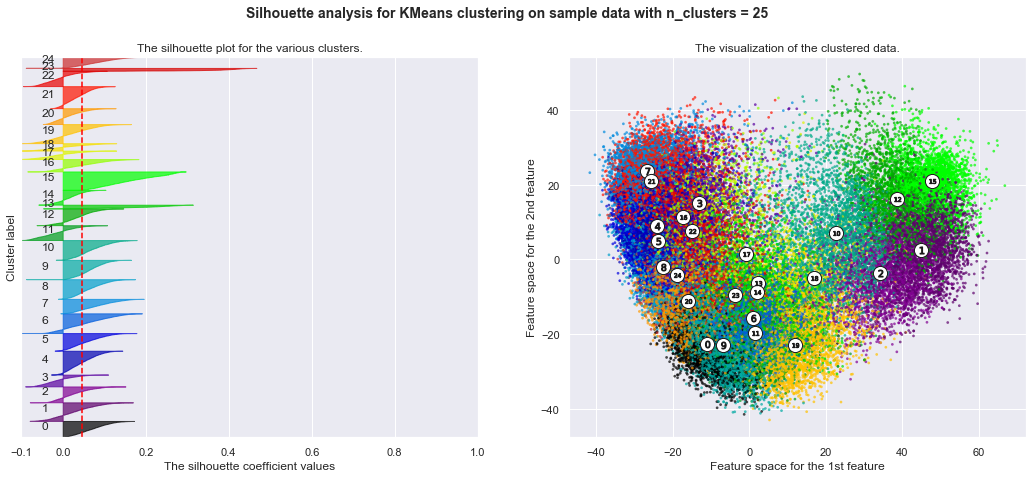

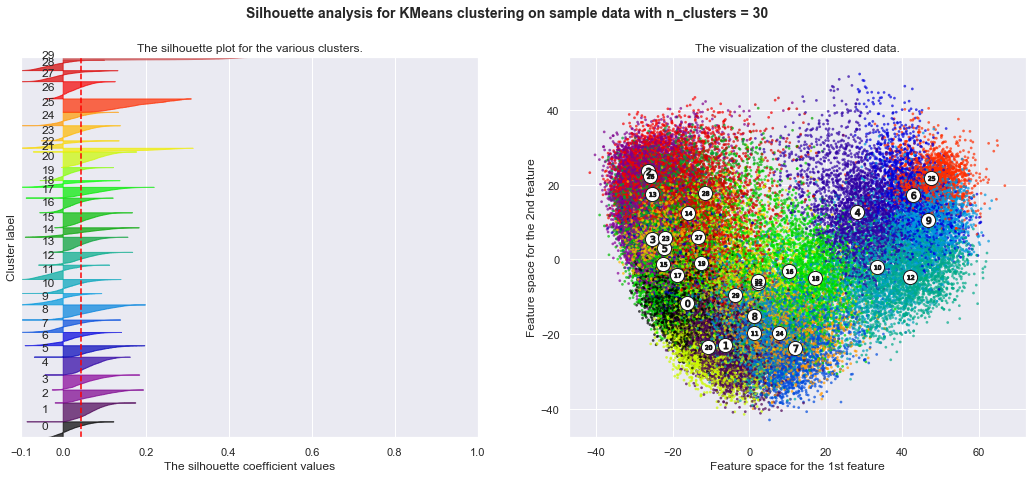

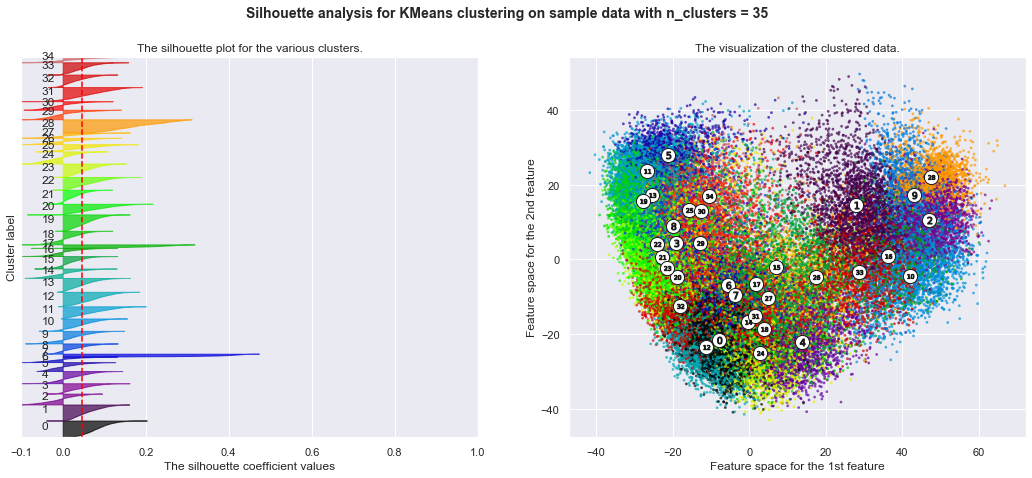

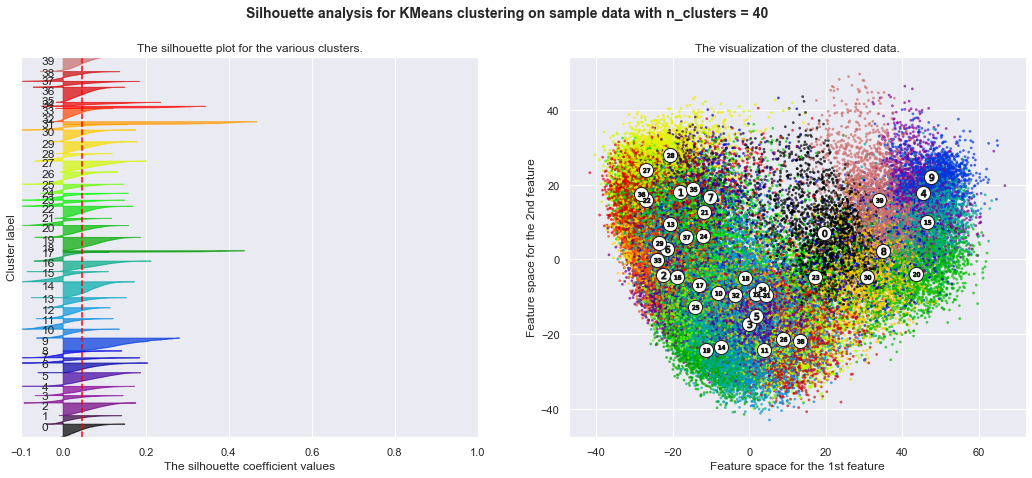

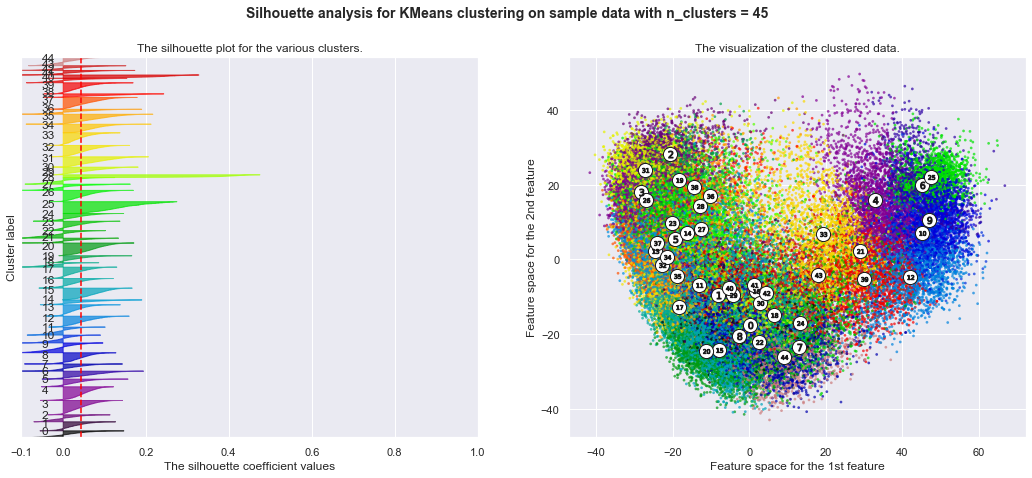

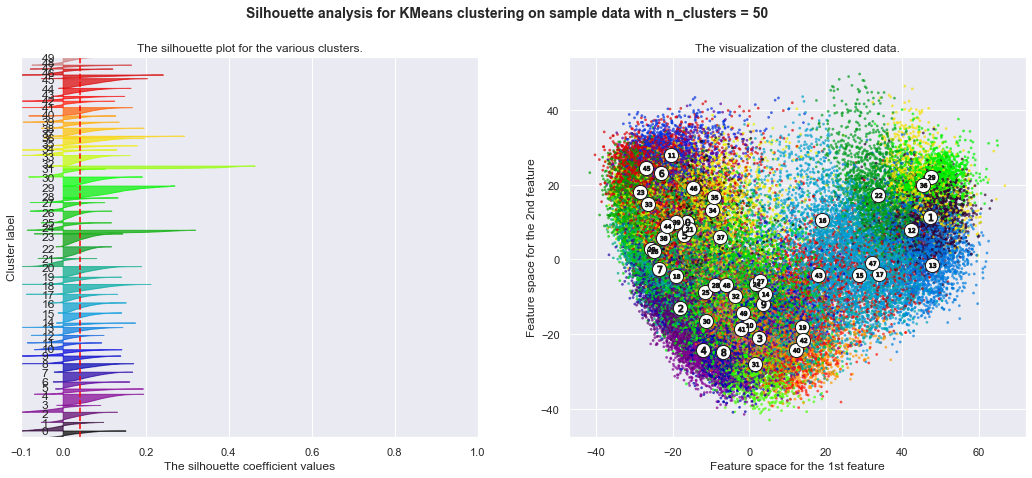

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# FROM: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.

values = range(10, 51, 5)

for k in values:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=seed)
    cluster_labels = clusterer.fit_predict(X_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()